In [6]:
import csv
import cv2
import numpy as np


lines = []
with open('./data/driving_log.csv') as csvfile:
#with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)


def generator(samples, batch_size):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                # 0:center, 1:left, 2:right
                for direction in range(3):
                    # read the image
                    name = './data/IMG/'+batch_sample[direction].split('/')[-1]
                    #name = './IMG/'+batch_sample[direction].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    images.append(image)
                    
                    # read the angle
                    correction = 0.1
                    if (direction == 0): # center
                        angle = float(line[3])
                    elif (direction == 1): # left
                        angle = float(line[3])-correction
                    elif (direction == 2): # right
                        angle = float(line[3])+correction
                    angles.append(angle)
                    
                    # flip the image and angle
                    image_flipped = np.fliplr(image)
                    images.append(image_flipped)
                    angle_flipped = -angle
                    angles.append(angle_flipped)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
BATCH_SIZE = 64
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)


from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
#from keras.backend import tf
import tensorflow as tf

model = Sequential()
model.add(Lambda(lambda x: x/255.0-0.5, input_shape=(160,320,3))) # 160*320*3
model.add(Cropping2D(cropping=((70,20), (10,10)))) # 70*300*3
#model.add(Lambda(lambda x: tf.image.resize_images(x, (68, 204)))) # 68*204*3
model.add(Lambda(lambda x: tf.image.resize_images(x, (68, 204)))) # 68*204*3
model.add(Convolution2D(24,5,5, border_mode = 'valid', activation="elu")) # 24@64*200
model.add(MaxPooling2D(pool_size=(2,2))) # 24@32*100
model.add(Convolution2D(36,5,5, border_mode = 'valid', activation="elu")) # 36@28*96
model.add(MaxPooling2D(pool_size=(2,2))) # 36@14*48
model.add(Convolution2D(48,5,5, border_mode = 'valid', activation="elu")) # 48@10*44
model.add(MaxPooling2D(pool_size=(2,2))) # 48@5*22
model.add(Convolution2D(64,3,3, border_mode = 'valid', activation="elu")) # 64@3*20
model.add(Convolution2D(64,3,3, border_mode = 'valid', activation="elu")) # 64@1*18
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1164))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch= len(train_samples),
                                     validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                                     nb_epoch=3, verbose=1)

model.save('model.h5')

Epoch 1/3
6144/6429 [===========================>..] - ETA: 0s - loss: 0.3591

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6528/6429 [==============================] - 11s - loss: 0.3422 - val_loss: 0.0277
Epoch 2/3
6528/6429 [==============================] - 10s - loss: 0.0155 - val_loss: 0.0083
Epoch 3/3
6528/6429 [==============================] - 10s - loss: 0.0061 - val_loss: 0.0047


dict_keys(['val_loss', 'loss'])


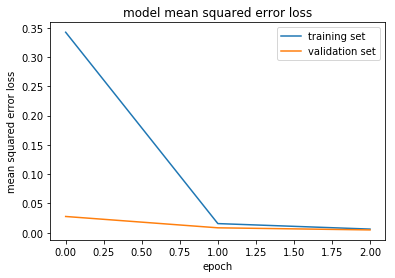

In [7]:
import matplotlib.pyplot as plt


# print the keys contained in the history object
print(history_object.history.keys())

# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()